In [1]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns",25)
pd.set_option("display.max_rows",250)
pd.options.display.float_format = '{:,.2f}'.format

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from urllib.request import urlopen
import json

# import folium

# new packages to pip install
import random
from patsy import dmatrices
import statsmodels.api as sm

In [2]:
### Import data
path = 'C:/Users/marcusdeckert/Desktop/2024 RPM Python/'
data5 = pd.read_feather(path + 'data5.ftr')

In [3]:
data5.head()

,pol_eff_year,ep_bi,ep_col,ee_bi,ee_col,incloss_bi,incloss_col,cc_bi,cc_col,modelyear,zip,pol_id,...,wtd_avg_travel_time,diploma_ntile,pop_density_ntile,unemployment_ntile,modelyear_null_flag,Modeled_Annual_Mileage_null_flag,Estimated_Current_Mileage_null_flag,Annual_Mileage_Estimate_null_flag,Number_of_Titling_Transactions_null_flag,LOO_years_null_flag,curr_owner_odo_cnt_null_flag,all_owner_odo_cnt_null_flag
0,2015,161.00,419.00,1.00,1.00,0.00,0.00,0,0,"2,010.00",45424,0,...,26.00,52.00,58.00,51.00,0,0,0,1,0,0,0,0
1,2017,269.00,416.00,1.00,1.00,0.00,0.00,0,0,"2,010.00",45424,0,...,26.00,52.00,58.00,51.00,0,0,0,0,0,0,0,0
2,2014,105.57,315.06,1.00,1.00,0.00,0.00,0,0,"2,010.00",45424,0,...,26.00,52.00,58.00,51.00,0,0,0,0,0,0,0,0
3,2016,258.00,425.00,1.00,1.00,0.00,0.00,0,0,"2,010.00",45424,0,...,26.00,52.00,58.00,51.00,0,0,0,0,0,0,0,0
4,2014,23.83,55.72,0.17,0.17,0.00,0.00,0,0,"2,007.00",45424,0,...,26.00,52.00,58.00,51.00,0,0,1,1,0,0,0,0


In [4]:
[i for i in data5.columns]

['pol_eff_year',
 'ep_bi',
 'ep_col',
 'ee_bi',
 'ee_col',
 'incloss_bi',
 'incloss_col',
 'cc_bi',
 'cc_col',
 'modelyear',
 'zip',
 'pol_id',
 'vin_id',
 'credit',
 'commute_flag',
 'veh_count_box',
 'driver_count_box',
 'veh_age_box',
 'coll_symb_ntile',
 'limit_bi',
 'ded_coll',
 'DrvAge_box',
 'male',
 'single',
 'widowed',
 'Date',
 'Modeled_Annual_Mileage',
 'Estimated_Current_Mileage',
 'Annual_Mileage_Estimate',
 'Number_of_Titling_Transactions',
 'Lien_Holder',
 'current_ownership_personal',
 'current_ownership_lease',
 'current_ownership_corp_govt',
 'LOO_years',
 'personal_use_flag',
 'rental_use_flag',
 'comm_use_flag',
 'fleet_use_flag',
 'corp_use_flag',
 'lease_flag',
 'curr_owner_odo_cnt',
 'all_owner_odo_cnt',
 'Severe_Problem_flag',
 'Branded_Title_flag',
 'Branded_Title_Loss_flag',
 'Severe_Accident_flag',
 'Other_Severe_Problem_flag',
 'Failed_Emissions_flag',
 'Nonsevere_Accident_flag',
 'Damage_flag',
 'Collision_Repair_Facility_flag',
 'Potential_Damage_flag',
 

In [5]:
### Let's fit Collision Pure Premium and remove all fields we don't need

remove_fields = ['ep_bi','ee_bi','incloss_bi','cc_bi','ep_col','cc_col','zip','pol_id','vin_id','Date']

print(data5.shape)
for i in remove_fields:
    del data5[i]
print(data5.shape)

(100443, 68)
(100443, 58)


In [6]:
### First we need to split data into train and test
### Because random numbers can change even with the same seed, we save our train and test for reproducible results later

data6 = data5.loc[data5['incloss_col'] >= 0].copy()
data6['pp'] = data6['incloss_col']/data6['ee_col']

def mad_tt_split(data,train_size):
    np.random.seed(seed=42)
    data['rand'] = np.random.randint(1, 101, data.shape[0])/100
    
    global data1_train, data1_test
    data1_train = data.loc[data['rand'] <= train_size].copy()
    data1_test = data.loc[data['rand'] > train_size].copy()
    
    del data1_train['rand']
    del data1_test['rand']
    
mad_tt_split(data6,.80)

# path = 'C:/Users/marcusdeckert/Box/marcusdeckert/Presentation Work/CARFAX Academy/Lesson 6 stuff/'
data1_train.reset_index().drop(columns = 'index').to_feather(path + 'data1_train')
data1_test.reset_index().drop(columns = 'index').to_feather(path + 'data1_test')

In [7]:
### Start with basic GLM fit using credit

model_construction = 'pp ~ credit'

y_train, X_train = dmatrices(model_construction, data=data1_train, return_type='dataframe')
y_test, X_test = dmatrices(model_construction, data=data1_test, return_type='dataframe')

glm = sm.GLM(y_train, X_train, family=sm.families.Tweedie(var_power = 1.4), var_weights=data1_train['ee_col'])
glm_results = glm.fit()
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     pp   No. Observations:                80134
Model:                            GLM   Df Residuals:                    80132
Model Family:                 Tweedie   Df Model:                            1
Link Function:                    Log   Scale:                          3527.6
Method:                          IRLS   Log-Likelihood:                -26270.
Date:                Fri, 22 Mar 2024   Deviance:                   5.8081e+06
Time:                        16:59:07   Pearson chi2:                 2.83e+08
No. Iterations:                     9   Pseudo R-squ. (CS):          0.0004544
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1641      0.146     28.468      0.0

In [8]:
### Residual plot function

def resid_plot(data,feature,act,pred,weight):
    x = data.groupby([feature]).agg({weight: 'sum', act: 'sum', pred: 'sum'}).reset_index()
    x['act'] = x[act]/x[weight]
    x['pred'] = x[pred]/x[weight]

    fig, ax = plt.subplots(figsize=(12,6))
    ax2  = ax.twinx()
    
    y_max = np.where(x['act'].max() > x['pred'].max(),x['act'].max(),x['pred'].max())*1.20
    ax2.set_ylim(0,y_max)

    x[weight].plot.bar(stacked=False, ax=ax, alpha=0.6)
    x['act'].plot(kind='line', ax=ax2, marker='o',linewidth = 0, legend='act')
    x['pred'].plot(kind='line', ax=ax2, marker='o', legend='pred')
    
    plt.xticks(ticks = x.index, labels = x[feature])

    ax.set(ylabel=weight, title = feature)
    plt.show()

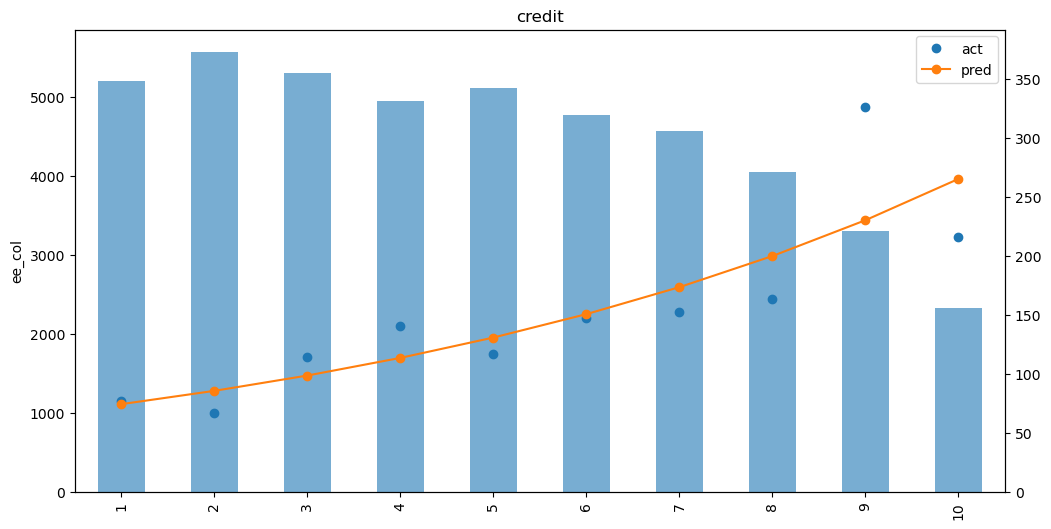

In [9]:
### Check actual vs predicted on train

data1_train['pred'] = glm_results.predict(X_train)
data1_train['incurred_pred'] = data1_train['pred']*data1_train['ee_col']

resid_plot(data1_train,'credit','incloss_col','incurred_pred','ee_col')

In [10]:
### Expand to list of inputs as independent variables

# Need a nice way to create the model_construction formula

def list_to_string(lst):
    for i, v in enumerate(lst):
        s = v
        if i == 0:
            string = v
        else:
            string = string + ' + ' + v
    return string

# path = 'C:/Users/marcusdeckert/Box/marcusdeckert/Presentation Work/CARFAX Academy/Lesson 6 stuff/'
data1_train = pd.read_feather(path + 'data1_train')
data1_test = pd.read_feather(path + 'data1_test')

facts = ['ee_col','incloss_col','pp']
remove_fields = []
var_list = [i for i in data1_train.columns if i not in remove_fields and i not in facts]

model_construction = 'pp ~ ' + list_to_string(var_list)

model_construction

'pp ~ pol_eff_year + modelyear + credit + commute_flag + veh_count_box + driver_count_box + veh_age_box + coll_symb_ntile + limit_bi + ded_coll + DrvAge_box + male + single + widowed + Modeled_Annual_Mileage + Estimated_Current_Mileage + Annual_Mileage_Estimate + Number_of_Titling_Transactions + Lien_Holder + current_ownership_personal + current_ownership_lease + current_ownership_corp_govt + LOO_years + personal_use_flag + rental_use_flag + comm_use_flag + fleet_use_flag + corp_use_flag + lease_flag + curr_owner_odo_cnt + all_owner_odo_cnt + Severe_Problem_flag + Branded_Title_flag + Branded_Title_Loss_flag + Severe_Accident_flag + Other_Severe_Problem_flag + Failed_Emissions_flag + Nonsevere_Accident_flag + Damage_flag + Collision_Repair_Facility_flag + Potential_Damage_flag + Odometer_Problem_flag + Repossession_flag + CPO_flag + wtd_avg_travel_time + diploma_ntile + pop_density_ntile + unemployment_ntile + modelyear_null_flag + Modeled_Annual_Mileage_null_flag + Estimated_Current_M

In [11]:
### Make into a function

def easy_glm(train,test,target,weight,var_list):
    global y_train, X_train
    model_construction = target + ' ~ ' + list_to_string(var_list)
    
    y_train, X_train = dmatrices(model_construction, data=train, return_type='dataframe')
    y_test, X_test = dmatrices(model_construction, data=test, return_type='dataframe')

    glm = sm.GLM(y_train, X_train, family=sm.families.Tweedie(var_power = 1.4), var_weights=train[weight])
    glm_results = glm.fit()
    print(glm_results.summary())
    
    global out_train, out_test
    out_train = train.copy()    
    out_train['pred'] = glm_results.predict(X_train)
    out_train['incurred_pred'] = out_train['pred']*out_train[weight]
    
    out_test = test.copy()    
    out_test['pred'] = glm_results.predict(X_test)
    out_test['incurred_pred'] = out_test['pred']*out_test[weight]

In [12]:
### Run our function

# path = 'C:/Users/marcusdeckert/Box/marcusdeckert/Presentation Work/CARFAX Academy/Lesson 6 stuff/'
data1_train = pd.read_feather(path + 'data1_train')
data1_test = pd.read_feather(path + 'data1_test')

data1_train['pop_density_ntile'] = round(data1_train['pop_density_ntile']/10,0)*10

facts = ['ee_col','incloss_col','pp']
remove_fields = []
var_list = [i for i in data1_train.columns if i not in remove_fields and i not in facts]

easy_glm(data1_train,data1_test,'pp','ee_col',var_list)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     pp   No. Observations:                80134
Model:                            GLM   Df Residuals:                    80079
Model Family:                 Tweedie   Df Model:                           54
Link Function:                    Log   Scale:                          2176.7
Method:                          IRLS   Log-Likelihood:                -24887.
Date:                Fri, 22 Mar 2024   Deviance:                   5.5038e+06
Time:                        16:59:17   Pearson chi2:                 1.74e+08
No. Iterations:                    29   Pseudo R-squ. (CS):           0.002478
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [13]:
### Function works, now let's get a lift chart

def lift_chart(test_data, act, pred, weight, bins):
    test_data['decile'] = (round(test_data.sort_values(by = 'pred')[weight].cumsum()/test_data[weight].sum(),2)*bins).apply(np.floor)
    test_data['decile'] = np.where(test_data['decile'] + 1 > bins ,bins,test_data['decile'] + 1)
    x = test_data.groupby(['decile'], dropna = False).agg({weight: 'sum', act: 'sum', pred: 'sum'}).reset_index()
    
    x['act'] = x[act]/x[weight]
    x['pred'] = x[pred]/x[weight]
    x.drop(columns = [act,pred], inplace = True)
    
    dfg = x
    fig, ax = plt.subplots(figsize=(12,6))
    ax2  = ax.twinx()
    
    y_min = np.where(dfg['act'].min() < dfg['pred'].min(),dfg['act'].min(),dfg['pred'].min())*.95
    y_max = np.where(dfg['act'].max() > dfg['pred'].max(),dfg['act'].max(),dfg['pred'].max())*1.05
    ax2.set_ylim(y_min,y_max)
    
    dfg[weight].plot.bar(stacked=False, ax=ax, alpha=0.6)
    dfg['act'].plot(kind='line', ax=ax2, marker='o', linewidth = 0, legend='act')
    dfg['pred'].plot(kind='line', ax=ax2, marker='o', legend='pred')
    plt.show()
    print(x)

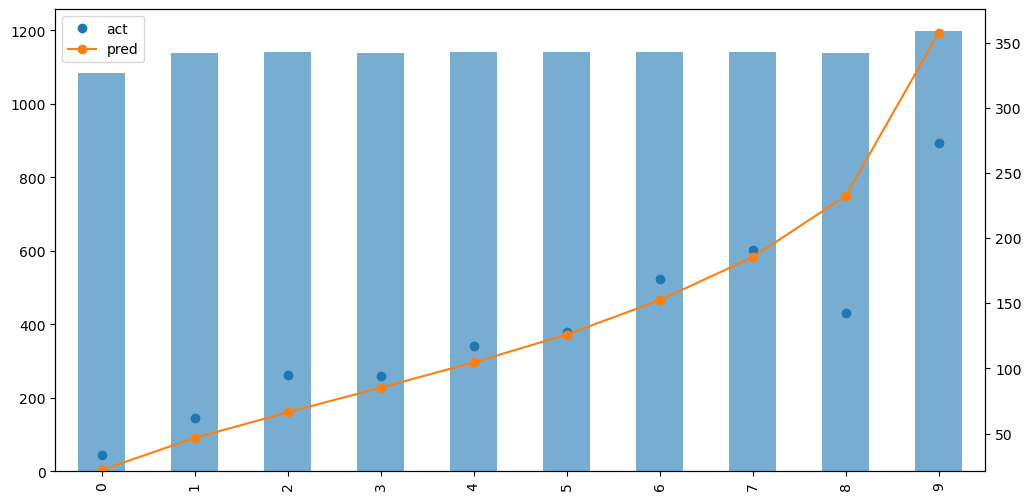

   decile   ee_col    act   pred
0    1.00 1,083.05  33.45  22.16
1    2.00 1,140.02  62.04  46.75
2    3.00 1,140.42  95.32  66.37
3    4.00 1,140.05  94.57  85.33
4    5.00 1,140.22 117.63 104.65
5    6.00 1,140.32 127.93 126.04
6    7.00 1,140.29 168.98 152.41
7    8.00 1,140.37 190.78 185.42
8    9.00 1,140.05 142.38 232.42
9   10.00 1,197.48 273.11 357.60


In [14]:
lift_chart(out_test, 'incloss_col', 'incurred_pred', 'ee_col', 10)

In [15]:
### Lift chart works, now let's get a widget for the residual plots

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(field):
    return resid_plot(out_train,field,'incloss_col','incurred_pred','ee_col')

interact(f, field = var_list)

interactive(children=(Dropdown(description='field', options=('pol_eff_year', 'modelyear', 'credit', 'commute_f…

<function __main__.f(field)>

In [16]:
### Now we have the basic items needed to build the GLM

In [17]:
### Starting below, go through the iterative process (adding new cells at each step to show the progress)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     pp   No. Observations:                80134
Model:                            GLM   Df Residuals:                    80079
Model Family:                 Tweedie   Df Model:                           54
Link Function:                    Log   Scale:                          2175.8
Method:                          IRLS   Log-Likelihood:                -24886.
Date:                Fri, 22 Mar 2024   Deviance:                   5.5040e+06
Time:                        16:59:32   Pearson chi2:                 1.74e+08
No. Iterations:                    29   Pseudo R-squ. (CS):           0.002478
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

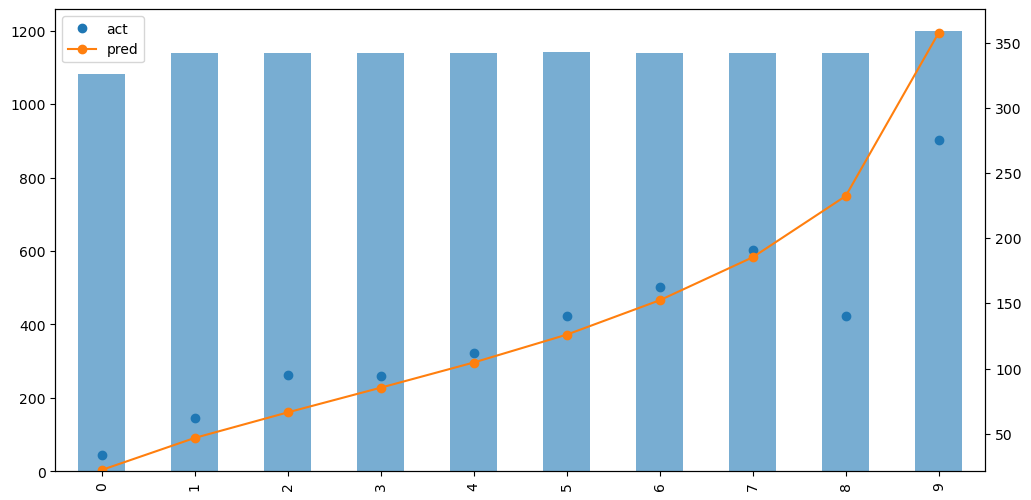

   decile   ee_col    act   pred
0    1.00 1,083.05  33.45  22.13
1    2.00 1,140.29  62.02  46.71
2    3.00 1,140.15  95.34  66.33
3    4.00 1,140.07  94.56  85.29
4    5.00 1,139.71 111.93 104.62
5    6.00 1,141.04 140.00 126.00
6    7.00 1,140.06 162.60 152.40
7    8.00 1,140.37 190.78 185.40
8    9.00 1,139.50 140.05 232.42
9   10.00 1,198.03 275.27 357.78


In [18]:
# path = 'C:/Users/marcusdeckert/Box/marcusdeckert/Presentation Work/CARFAX Academy/Lesson 6 stuff/'
data1_train = pd.read_feather(path + 'data1_train')
data1_test = pd.read_feather(path + 'data1_test')

facts = ['ee_col','incloss_col','pp']
remove_fields = []
var_list = [i for i in data1_train.columns if i not in remove_fields and i not in facts]

easy_glm(data1_train,data1_test,'pp','ee_col',var_list)

lift_chart(out_test, 'incloss_col', 'incurred_pred', 'ee_col', 10)

In [21]:
### Let's first evaluate the vehicle history flags p values

Severe_Problem_flag                         0.983
Branded_Title_flag                          0.977
Branded_Title_Loss_flag                     0.455
Severe_Accident_flag                        0.681
Other_Severe_Problem_flag                   0.733
Failed_Emissions_flag                       0.505
Nonsevere_Accident_flag                     0.704
Damage_flag                                 0.859
Collision_Repair_Facility_flag              0.508
Potential_Damage_flag                       0.916
Odometer_Problem_flag                       0.231
Repossession_flag                           0.959
CPO_flag                                    0.874

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     pp   No. Observations:                80134
Model:                            GLM   Df Residuals:                    80089
Model Family:                 Tweedie   Df Model:                           44
Link Function:                    Log   Scale:                          2151.7
Method:                          IRLS   Log-Likelihood:                -24861.
Date:                Fri, 22 Mar 2024   Deviance:                   5.5106e+06
Time:                        17:00:07   Pearson chi2:                 1.72e+08
No. Iterations:                    30   Pseudo R-squ. (CS):           0.002468
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

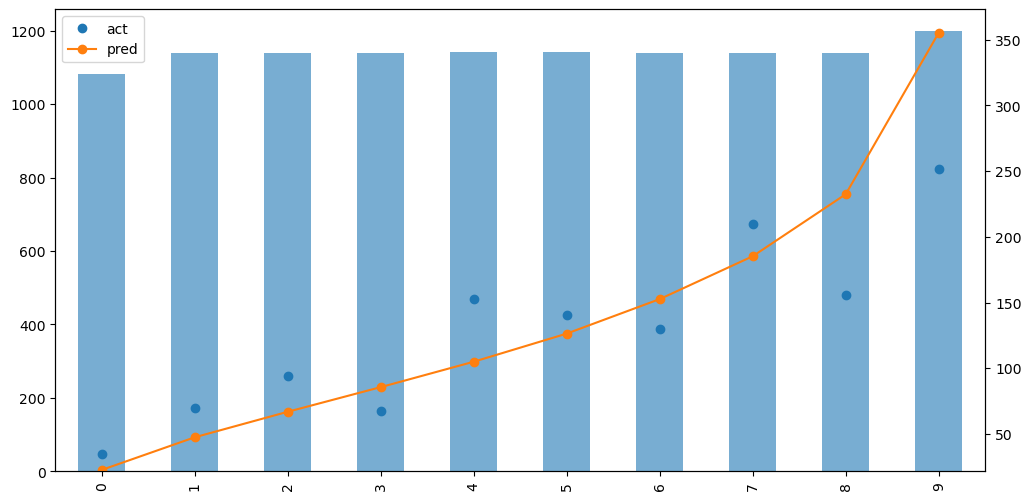

   decile   ee_col    act   pred
0    1.00 1,083.00  34.58  22.63
1    2.00 1,140.22  69.80  47.46
2    3.00 1,139.92  94.28  66.88
3    4.00 1,140.09  67.60  85.63
4    5.00 1,140.76 153.07 104.97
5    6.00 1,140.31 140.51 126.37
6    7.00 1,140.05 129.95 152.63
7    8.00 1,140.08 209.99 185.25
8    9.00 1,140.11 155.72 232.44
9   10.00 1,197.72 251.77 355.33


In [20]:
# Many of these are correlated with each other, so we don't want to remove them all just yet.  Let's remove everything but Branded_Title_Loss_flag, Collision_Repair_Facility_flag, and Odometer_Problem_flag

facts = ['ee_col','incloss_col','pp']
remove_fields = [
    'Severe_Problem_flag','Branded_Title_flag','Severe_Accident_flag','Other_Severe_Problem_flag','Failed_Emissions_flag','Nonsevere_Accident_flag','Damage_flag','Potential_Damage_flag','Repossession_flag','CPO_flag' #VH damage flags
                ]
var_list = [i for i in data1_train.columns if i not in remove_fields and i not in facts]

easy_glm(data1_train,data1_test,'pp','ee_col',var_list)

lift_chart(out_test, 'incloss_col', 'incurred_pred', 'ee_col', 10)

In [ ]:
### Next evaluate the historical ownership type flags p values

personal_use_flag   0.922
rental_use_flag     0.456
comm_use_flag       0.498
fleet_use_flag      0.944
corp_use_flag       0.776
lease_flag          0.046

# Remove all but lease_flag

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     pp   No. Observations:                80134
Model:                            GLM   Df Residuals:                    80094
Model Family:                 Tweedie   Df Model:                           39
Link Function:                    Log   Scale:                          2154.7
Method:                          IRLS   Log-Likelihood:                -24864.
Date:                Fri, 22 Mar 2024   Deviance:                   5.5127e+06
Time:                        17:00:20   Pearson chi2:                 1.73e+08
No. Iterations:                    39   Pseudo R-squ. (CS):           0.002452
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

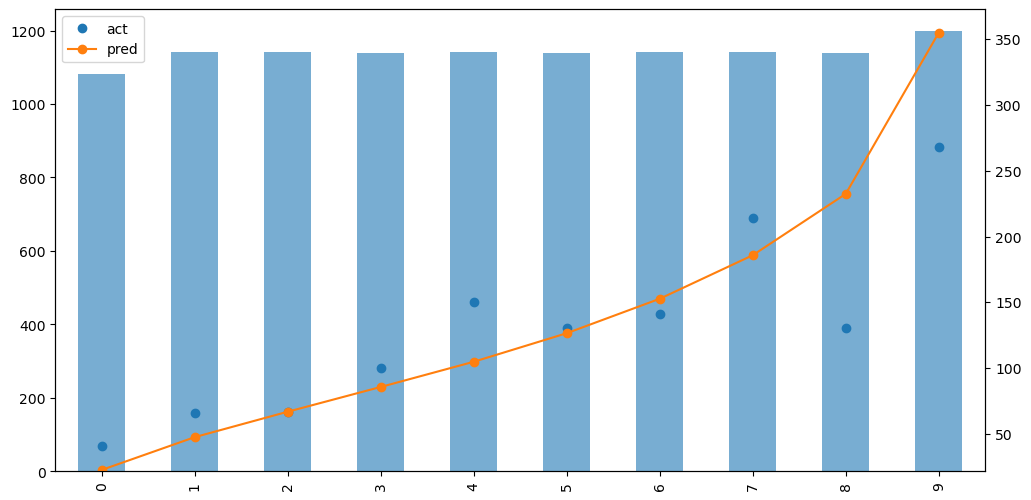

   decile   ee_col    act   pred
0    1.00 1,082.82  40.49  22.68
1    2.00 1,140.54  66.11  47.58
2    3.00 1,140.24  66.68  66.90
3    4.00 1,139.99  99.90  85.71
4    5.00 1,140.50 150.22 104.86
5    6.00 1,139.83 130.51 126.55
6    7.00 1,140.42 140.86 152.71
7    8.00 1,140.29 214.08 185.79
8    9.00 1,140.07 130.13 232.40
9   10.00 1,197.56 267.79 354.83


In [22]:
facts = ['ee_col','incloss_col','pp']
remove_fields = [
    'Severe_Problem_flag','Branded_Title_flag','Severe_Accident_flag','Other_Severe_Problem_flag','Failed_Emissions_flag','Nonsevere_Accident_flag','Damage_flag','Potential_Damage_flag','Repossession_flag','CPO_flag', #VH damage flags
    'personal_use_flag','rental_use_flag','comm_use_flag','fleet_use_flag','corp_use_flag' #VH historical ownership flags
                ]
var_list = [i for i in data1_train.columns if i not in remove_fields and i not in facts]

easy_glm(data1_train,data1_test,'pp','ee_col',var_list)

lift_chart(out_test, 'incloss_col', 'incurred_pred', 'ee_col', 10)

In [ ]:
### Next evaluate the current ownership type flags p values

current_ownership_personal  0.842
current_ownership_lease     0.849
current_ownership_corp_govt 0.890

# Remove all

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     pp   No. Observations:                80134
Model:                            GLM   Df Residuals:                    80097
Model Family:                 Tweedie   Df Model:                           36
Link Function:                    Log   Scale:                          2086.4
Method:                          IRLS   Log-Likelihood:                -24787.
Date:                Fri, 22 Mar 2024   Deviance:                   5.5143e+06
Time:                        17:00:28   Pearson chi2:                 1.67e+08
No. Iterations:                    42   Pseudo R-squ. (CS):           0.002523
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

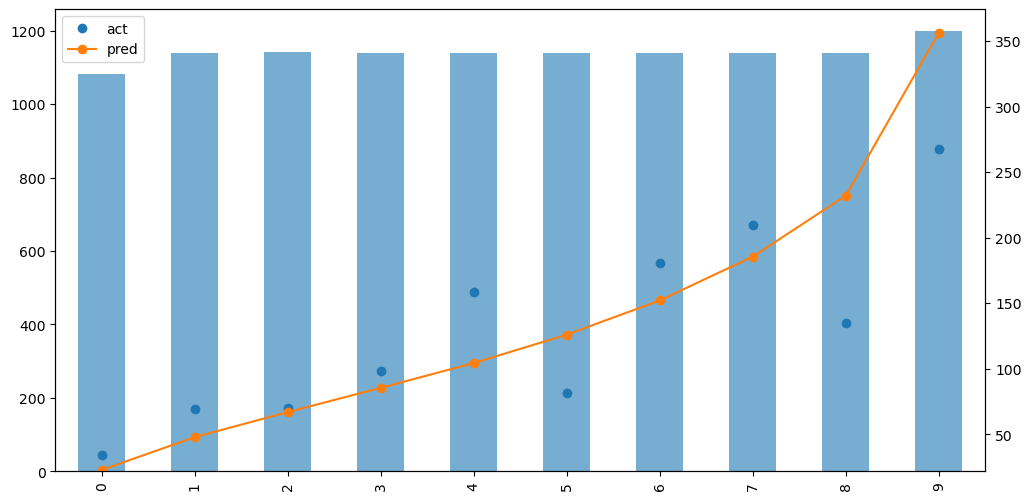

   decile   ee_col    act   pred
0    1.00 1,082.89  34.58  22.96
1    2.00 1,139.71  69.49  47.91
2    3.00 1,140.69  70.38  67.02
3    4.00 1,140.19  98.28  85.53
4    5.00 1,140.37 158.23 104.41
5    6.00 1,140.04  81.95 126.08
6    7.00 1,140.34 180.65 152.13
7    8.00 1,140.17 210.01 185.55
8    9.00 1,140.06 134.99 232.01
9   10.00 1,197.80 267.88 356.26


In [23]:
facts = ['ee_col','incloss_col','pp']
remove_fields = [
    'Severe_Problem_flag','Branded_Title_flag','Severe_Accident_flag','Other_Severe_Problem_flag','Failed_Emissions_flag','Nonsevere_Accident_flag','Damage_flag','Potential_Damage_flag','Repossession_flag','CPO_flag', #VH damage flags
    'personal_use_flag','rental_use_flag','comm_use_flag','fleet_use_flag','corp_use_flag', #VH historical ownership flags
    'current_ownership_personal','current_ownership_lease','current_ownership_corp_govt' #VH current ownership flags
                ]
var_list = [i for i in data1_train.columns if i not in remove_fields and i not in facts]

easy_glm(data1_train,data1_test,'pp','ee_col',var_list)

lift_chart(out_test, 'incloss_col', 'incurred_pred', 'ee_col', 10)

In [ ]:
### Next evaluate the geodemographics p values

wtd_avg_travel_time 0.357
diploma_ntile       0.492
pop_density_ntile   0.058
unemployment_ntile  0.271

# Remove all but pop_density_ntile

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     pp   No. Observations:                80134
Model:                            GLM   Df Residuals:                    80100
Model Family:                 Tweedie   Df Model:                           33
Link Function:                    Log   Scale:                          2032.3
Method:                          IRLS   Log-Likelihood:                -24726.
Date:                Fri, 22 Mar 2024   Deviance:                   5.5194e+06
Time:                        17:00:35   Pearson chi2:                 1.63e+08
No. Iterations:                    35   Pseudo R-squ. (CS):           0.002559
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

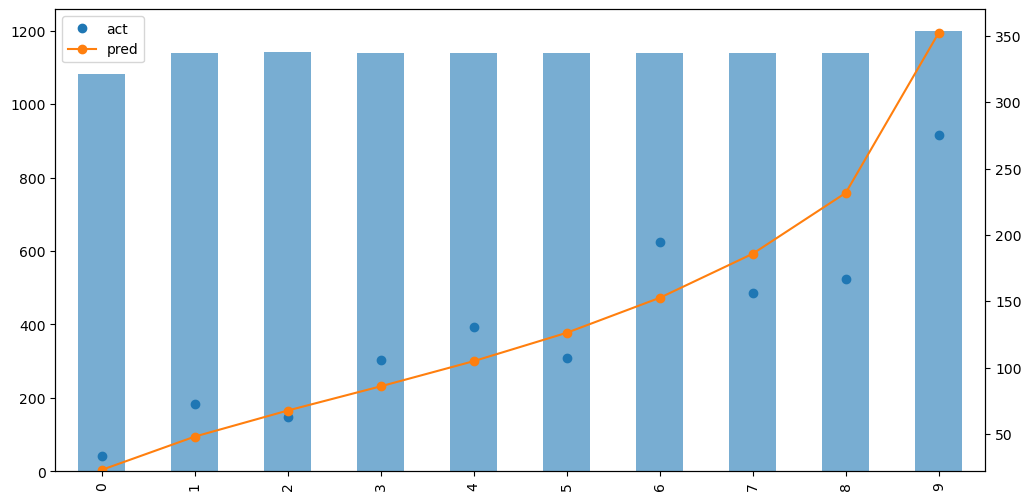

   decile   ee_col    act   pred
0    1.00 1,083.16  33.71  23.00
1    2.00 1,139.77  72.55  48.07
2    3.00 1,140.57  62.49  67.71
3    4.00 1,140.22 105.66  85.96
4    5.00 1,140.37 130.63 104.92
5    6.00 1,139.98 107.63 126.29
6    7.00 1,139.95 194.97 152.64
7    8.00 1,140.37 156.06 185.83
8    9.00 1,140.04 166.98 231.68
9   10.00 1,197.82 275.38 352.32


In [24]:
facts = ['ee_col','incloss_col','pp']
remove_fields = [
    'Severe_Problem_flag','Branded_Title_flag','Severe_Accident_flag','Other_Severe_Problem_flag','Failed_Emissions_flag','Nonsevere_Accident_flag','Damage_flag','Potential_Damage_flag','Repossession_flag','CPO_flag', #VH damage flags
    'personal_use_flag','rental_use_flag','comm_use_flag','fleet_use_flag','corp_use_flag', #VH historical ownership flags
    'current_ownership_personal','current_ownership_lease','current_ownership_corp_govt', #VH current ownership flags
    'wtd_avg_travel_time','diploma_ntile','unemployment_ntile' #geodemographics
                ]
var_list = [i for i in data1_train.columns if i not in remove_fields and i not in facts]

easy_glm(data1_train,data1_test,'pp','ee_col',var_list)

lift_chart(out_test, 'incloss_col', 'incurred_pred', 'ee_col', 10)

In [ ]:
### Next evaluate the policy information

pol_eff_year       0.625 # Normally, pol_eff_year would be categorical and left in no matter what; let's simplify and remove it
credit             0.000
commute_flag       0.664 # Remove
veh_count_box      0.155
driver_count_box   0.377 # Remove
veh_age_box        0.007
coll_symb_ntile    0.021
limit_bi           0.367 # Remove
ded_coll           0.566
DrvAge_box         0.057
male               0.079
single             0.125
widowed            0.006

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     pp   No. Observations:                80134
Model:                            GLM   Df Residuals:                    80104
Model Family:                 Tweedie   Df Model:                           29
Link Function:                    Log   Scale:                          2041.7
Method:                          IRLS   Log-Likelihood:                -24740.
Date:                Fri, 22 Mar 2024   Deviance:                   5.5297e+06
Time:                        17:00:43   Pearson chi2:                 1.64e+08
No. Iterations:                    41   Pseudo R-squ. (CS):           0.002484
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

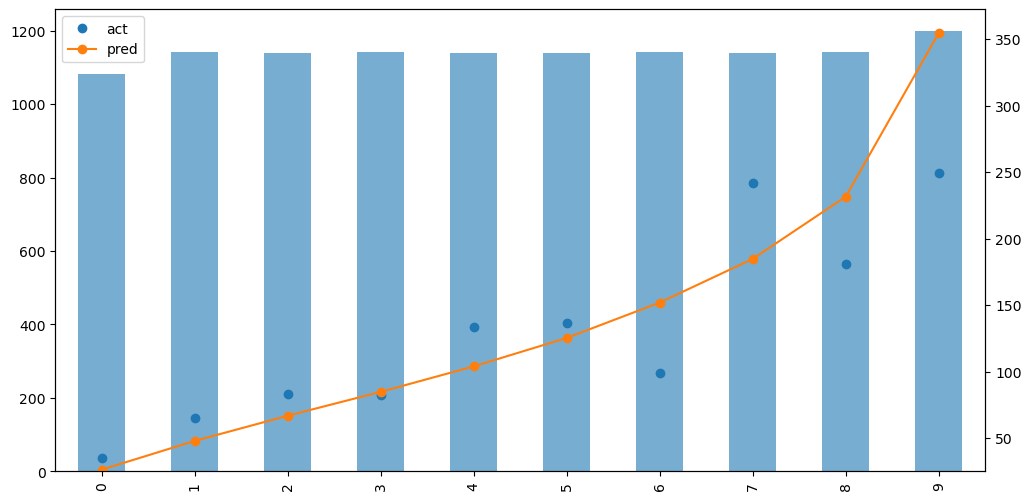

   decile   ee_col    act   pred
0    1.00 1,082.77  35.32  26.24
1    2.00 1,140.44  65.25  47.88
2    3.00 1,139.70  83.14  66.81
3    4.00 1,140.71  82.06  84.77
4    5.00 1,140.04 133.90 103.93
5    6.00 1,140.15 136.60 125.32
6    7.00 1,140.38  99.25 151.94
7    8.00 1,139.79 242.05 184.77
8    9.00 1,140.59 180.69 231.59
9   10.00 1,197.69 249.23 354.70


In [25]:
facts = ['ee_col','incloss_col','pp']
remove_fields = [
    'Severe_Problem_flag','Branded_Title_flag','Severe_Accident_flag','Other_Severe_Problem_flag','Failed_Emissions_flag','Nonsevere_Accident_flag','Damage_flag','Potential_Damage_flag','Repossession_flag','CPO_flag', #VH damage flags
    'personal_use_flag','rental_use_flag','comm_use_flag','fleet_use_flag','corp_use_flag', #VH historical ownership flags
    'current_ownership_personal','current_ownership_lease','current_ownership_corp_govt', #VH current ownership flags
    'wtd_avg_travel_time','diploma_ntile','unemployment_ntile', #geodemographics
    'pol_eff_year','commute_flag','driver_count_box','limit_bi' #policy info
                ]
var_list = [i for i in data1_train.columns if i not in remove_fields and i not in facts]

easy_glm(data1_train,data1_test,'pp','ee_col',var_list)

lift_chart(out_test, 'incloss_col', 'incurred_pred', 'ee_col', 10)

In [ ]:
### Next evaluate the remaining features for this first pass

Modeled_Annual_Mileage          0.052
Estimated_Current_Mileage       0.830 # Remove
Annual_Mileage_Estimate         0.867
Number_of_Titling_Transactions  0.979
Lien_Holder                     0.694 # Remove
LOO_years                       0.206
curr_owner_odo_cnt              0.245 # correlated with Annual_Mileage_Estimate & Number_of_Titling_Transactions
all_owner_odo_cnt               0.165 # correlated with Annual_Mileage_Estimate & Number_of_Titling_Transactions

# prefer to try removing odo_cnt and try # correlated with Annual_Mileage_Estimate & Number_of_Titling_Transactions

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     pp   No. Observations:                80134
Model:                            GLM   Df Residuals:                    80110
Model Family:                 Tweedie   Df Model:                           23
Link Function:                    Log   Scale:                          2023.1
Method:                          IRLS   Log-Likelihood:                -24720.
Date:                Fri, 22 Mar 2024   Deviance:                   5.5347e+06
Time:                        17:00:47   Pearson chi2:                 1.62e+08
No. Iterations:                    17   Pseudo R-squ. (CS):           0.002476
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

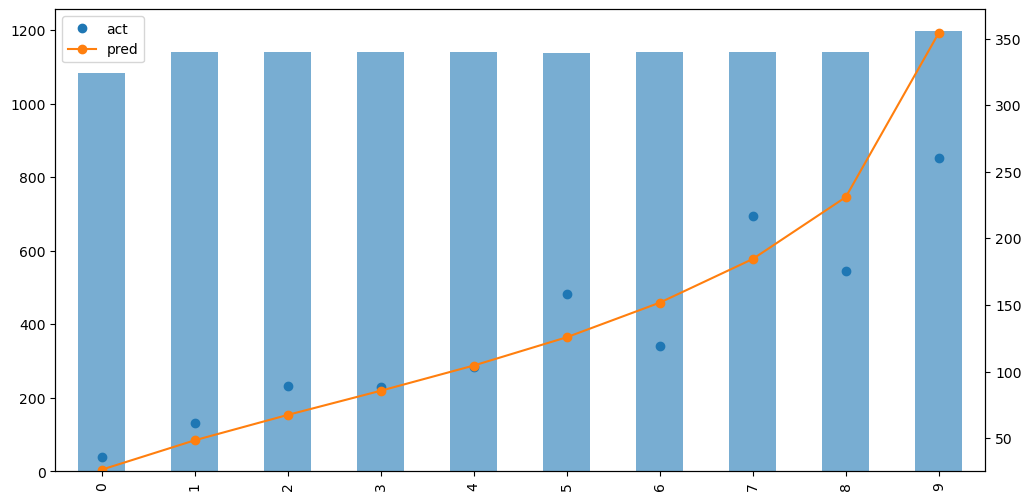

   decile   ee_col    act   pred
0    1.00 1,083.13  35.67  26.30
1    2.00 1,140.30  61.17  48.35
2    3.00 1,140.05  88.87  67.40
3    4.00 1,140.09  88.04  85.56
4    5.00 1,140.49 103.40 104.50
5    6.00 1,139.60 158.14 125.74
6    7.00 1,140.56 119.11 151.71
7    8.00 1,140.10 216.80 184.51
8    9.00 1,140.68 175.23 230.97
9   10.00 1,197.26 260.54 354.27


In [26]:
# Trying without odo_cnt features

facts = ['ee_col','incloss_col','pp']
remove_fields = [
    'Severe_Problem_flag','Branded_Title_flag','Severe_Accident_flag','Other_Severe_Problem_flag','Failed_Emissions_flag','Nonsevere_Accident_flag','Damage_flag','Potential_Damage_flag','Repossession_flag','CPO_flag', #VH damage flags
    'personal_use_flag','rental_use_flag','comm_use_flag','fleet_use_flag','corp_use_flag', #VH historical ownership flags
    'current_ownership_personal','current_ownership_lease','current_ownership_corp_govt', #VH current ownership flags
    'wtd_avg_travel_time','diploma_ntile','unemployment_ntile', #geodemographics
    'pol_eff_year','commute_flag','driver_count_box','limit_bi', #policy info
    'Estimated_Current_Mileage','Estimated_Current_Mileage_null_flag','Estimated_Current_Mileage_null_flag','Lien_Holder','curr_owner_odo_cnt','curr_owner_odo_cnt_null_flag','all_owner_odo_cnt','all_owner_odo_cnt_null_flag' #VH remainder
                ]
var_list = [i for i in data1_train.columns if i not in remove_fields and i not in facts]

easy_glm(data1_train,data1_test,'pp','ee_col',var_list)

lift_chart(out_test, 'incloss_col', 'incurred_pred', 'ee_col', 10)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     pp   No. Observations:                80134
Model:                            GLM   Df Residuals:                    80110
Model Family:                 Tweedie   Df Model:                           23
Link Function:                    Log   Scale:                          2098.6
Method:                          IRLS   Log-Likelihood:                -24807.
Date:                Fri, 22 Mar 2024   Deviance:                   5.5371e+06
Time:                        17:00:52   Pearson chi2:                 1.68e+08
No. Iterations:                    30   Pseudo R-squ. (CS):           0.002373
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

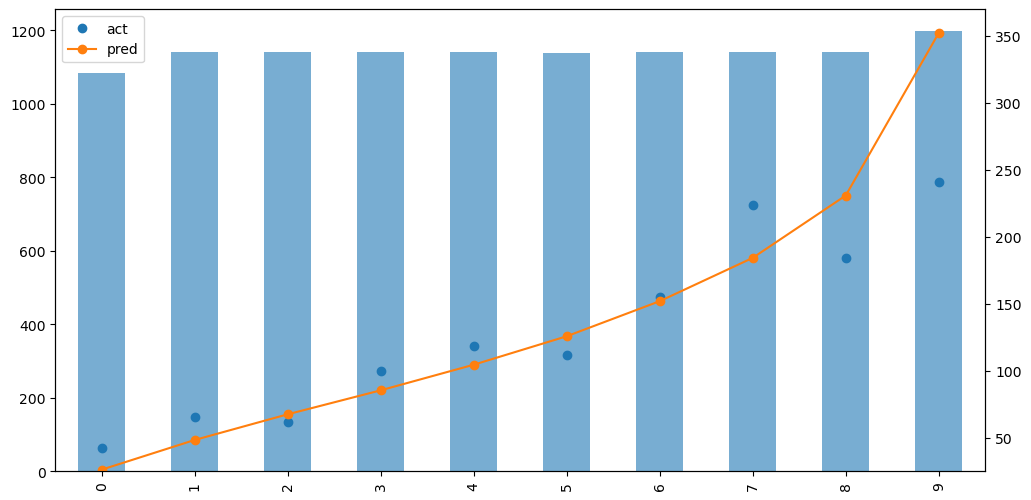

   decile   ee_col    act   pred
0    1.00 1,083.10  42.61  26.52
1    2.00 1,139.92  65.96  48.67
2    3.00 1,140.22  61.74  67.84
3    4.00 1,140.18  99.98  85.74
4    5.00 1,140.50 119.17 104.85
5    6.00 1,139.89 112.37 126.10
6    7.00 1,140.12 155.65 152.30
7    8.00 1,140.76 224.45 184.62
8    9.00 1,140.27 184.76 231.16
9   10.00 1,197.30 241.50 352.50


In [27]:
# Didn't work - now try with odo_cnt and remove Annual_Mileage_Estimate & Number_of_Titling_Transactions

facts = ['ee_col','incloss_col','pp']
remove_fields = [
    'Severe_Problem_flag','Branded_Title_flag','Severe_Accident_flag','Other_Severe_Problem_flag','Failed_Emissions_flag','Nonsevere_Accident_flag','Damage_flag','Potential_Damage_flag','Repossession_flag','CPO_flag', #VH damage flags
    'personal_use_flag','rental_use_flag','comm_use_flag','fleet_use_flag','corp_use_flag', #VH historical ownership flags
    'current_ownership_personal','current_ownership_lease','current_ownership_corp_govt', #VH current ownership flags
    'wtd_avg_travel_time','diploma_ntile','unemployment_ntile', #geodemographics
    'pol_eff_year','commute_flag','driver_count_box','limit_bi', #policy info
    'Estimated_Current_Mileage','Estimated_Current_Mileage_null_flag','Lien_Holder', 'Annual_Mileage_Estimate', 'Annual_Mileage_Estimate_null_flag', 'Number_of_Titling_Transactions', 'Number_of_Titling_Transactions_null_flag' #VH remainder
                ]
var_list = [i for i in data1_train.columns if i not in remove_fields and i not in facts]

easy_glm(data1_train,data1_test,'pp','ee_col',var_list)

lift_chart(out_test, 'incloss_col', 'incurred_pred', 'ee_col', 10)

In [ ]:
# Let's check the residual plots and tidy things up

In [28]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(field):
    return resid_plot(out_train,field,'incloss_col','incurred_pred','ee_col')

interact(f, field = var_list)

interactive(children=(Dropdown(description='field', options=('modelyear', 'credit', 'veh_count_box', 'veh_age_…

<function __main__.f(field)>

In [ ]:
### Notes from residual plots

credit; combine 1-2 & 8-10
veh_count_box; combine 2-4
veh_age_box; combine 0-2 & 12-15
ded_coll; combine 250-500
DrvAge_box; combine 17-24
Modeled_Annual_Mileage; combine 13K+ together
LOO_years; combine 8+ together
curr_owner_odo_cnt & all_owner_odo_cnt; directions are opposite - lets pick one of them after the next fit
Branded_Title_Loss_flag & Collision_Repair_Facility_flag; these are indicating discounts and we need to remove
pop_density_ntile; combined <= 5 & >= 85

Also, review residual plots for Annual_Mileage_Estimate & Number_of_Titling_Transactions to be sure no signal is missed

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     pp   No. Observations:                80134
Model:                            GLM   Df Residuals:                    80112
Model Family:                 Tweedie   Df Model:                           21
Link Function:                    Log   Scale:                          1995.9
Method:                          IRLS   Log-Likelihood:                -24689.
Date:                Fri, 22 Mar 2024   Deviance:                   5.5381e+06
Time:                        17:00:57   Pearson chi2:                 1.60e+08
No. Iterations:                    31   Pseudo R-squ. (CS):           0.002489
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

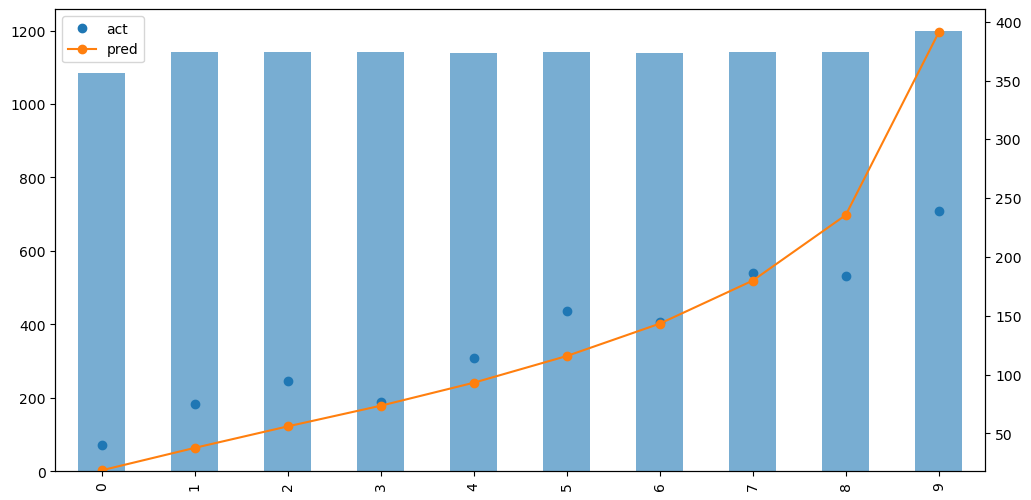

   decile   ee_col    act   pred
0    1.00 1,083.12  39.84  18.68
1    2.00 1,140.19  75.27  37.75
2    3.00 1,140.32  94.87  56.01
3    4.00 1,140.27  76.53  73.57
4    5.00 1,140.02 113.74  93.11
5    6.00 1,140.27 154.15 115.81
6    7.00 1,139.69 145.09 143.33
7    8.00 1,140.57 186.00 179.91
8    9.00 1,140.22 183.85 235.62
9   10.00 1,197.59 238.86 390.90


In [29]:
### Data changes

def box_var(data,var,low,high):
    data[var] = np.where(data[var] > high, high, data[var])
    data[var] = np.where(data[var] < low, low, data[var])
    
box_var(data1_train,'credit',2,8)
box_var(data1_train,'veh_count_box',1,2)
box_var(data1_train,'veh_age_box',2,12)
box_var(data1_train,'ded_coll',500,1000)
box_var(data1_train,'DrvAge_box',24,999)
box_var(data1_train,'Modeled_Annual_Mileage',0,13000)
box_var(data1_train,'LOO_years',0,8)
box_var(data1_train,'pop_density_ntile',5,85)


### GLM fit
facts = ['ee_col','incloss_col','pp']
remove_fields = [
    'Severe_Problem_flag','Branded_Title_flag','Severe_Accident_flag','Other_Severe_Problem_flag','Failed_Emissions_flag','Nonsevere_Accident_flag','Damage_flag','Potential_Damage_flag','Repossession_flag','CPO_flag', #VH damage flags
    'personal_use_flag','rental_use_flag','comm_use_flag','fleet_use_flag','corp_use_flag', #VH historical ownership flags
    'current_ownership_personal','current_ownership_lease','current_ownership_corp_govt', #VH current ownership flags
    'wtd_avg_travel_time','diploma_ntile','unemployment_ntile', #geodemographics
    'pol_eff_year','commute_flag','driver_count_box','limit_bi', #policy info
    'Estimated_Current_Mileage','Estimated_Current_Mileage_null_flag','Lien_Holder', 'Annual_Mileage_Estimate', 'Annual_Mileage_Estimate_null_flag', 'Number_of_Titling_Transactions', 'Number_of_Titling_Transactions_null_flag', #VH remainder
    'Branded_Title_Loss_flag','Collision_Repair_Facility_flag' #2nd round VH damage flags
    
                ]
var_list = [i for i in data1_train.columns if i not in remove_fields and i not in facts]

easy_glm(data1_train,data1_test,'pp','ee_col',var_list)

lift_chart(out_test, 'incloss_col', 'incurred_pred', 'ee_col', 10)

In [30]:
def f(field):
    return resid_plot(out_train,field,'incloss_col','incurred_pred','ee_col')

interact(f, field = var_list + ['Annual_Mileage_Estimate','Number_of_Titling_Transactions'])

interactive(children=(Dropdown(description='field', options=('modelyear', 'credit', 'veh_count_box', 'veh_age_…

<function __main__.f(field)>

In [ ]:
### Further notes from more review

ded_coll; Remove
Modeled_Annual_Mileage; group further - 12K+ & <=8K
LOO_years; group further - <=2
curr_owner_odo_cnt; Remove due to negative direction
Odometer_Problem_flag; Remove

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     pp   No. Observations:                80134
Model:                            GLM   Df Residuals:                    80115
Model Family:                 Tweedie   Df Model:                           18
Link Function:                    Log   Scale:                          1977.7
Method:                          IRLS   Log-Likelihood:                -24668.
Date:                Fri, 22 Mar 2024   Deviance:                   5.5383e+06
Time:                        17:01:01   Pearson chi2:                 1.58e+08
No. Iterations:                    30   Pseudo R-squ. (CS):           0.002510
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

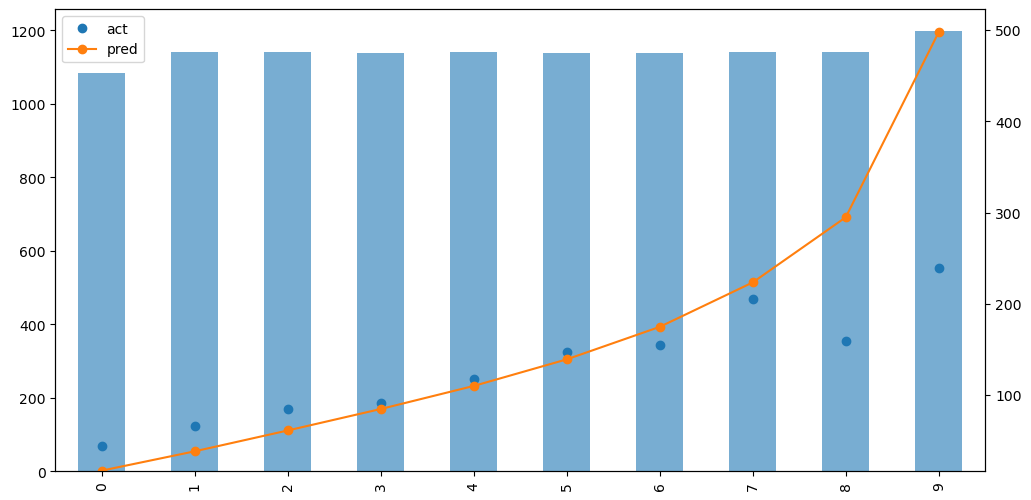

   decile   ee_col    act   pred
0    1.00 1,082.94  43.59  16.95
1    2.00 1,140.05  65.54  38.15
2    3.00 1,140.34  84.95  61.00
3    4.00 1,139.73  90.76  84.55
4    5.00 1,140.95 117.95 109.85
5    6.00 1,139.90 147.59 139.00
6    7.00 1,139.80 155.25 174.66
7    8.00 1,141.00 204.85 223.41
8    9.00 1,140.11 159.18 294.85
9   10.00 1,197.43 238.71 498.00


In [31]:
### Data changes
box_var(data1_train,'Modeled_Annual_Mileage',8000,12000)
box_var(data1_train,'LOO_years',2,8)


### GLM fit
facts = ['ee_col','incloss_col','pp']
remove_fields = [
    'Severe_Problem_flag','Branded_Title_flag','Severe_Accident_flag','Other_Severe_Problem_flag','Failed_Emissions_flag','Nonsevere_Accident_flag','Damage_flag','Potential_Damage_flag','Repossession_flag','CPO_flag', #VH damage flags
    'personal_use_flag','rental_use_flag','comm_use_flag','fleet_use_flag','corp_use_flag', #VH historical ownership flags
    'current_ownership_personal','current_ownership_lease','current_ownership_corp_govt', #VH current ownership flags
    'wtd_avg_travel_time','diploma_ntile','unemployment_ntile', #geodemographics
    'pol_eff_year','commute_flag','driver_count_box','limit_bi', #policy info
    'Estimated_Current_Mileage','Estimated_Current_Mileage_null_flag','Lien_Holder', 'Annual_Mileage_Estimate', 'Annual_Mileage_Estimate_null_flag', 'Number_of_Titling_Transactions', 'Number_of_Titling_Transactions_null_flag', #VH remainder
    'Branded_Title_Loss_flag','Collision_Repair_Facility_flag', #2nd round VH damage flags
    'ded_coll','curr_owner_odo_cnt','curr_owner_odo_cnt_null_flag','Odometer_Problem_flag' #3rd round
    
                ]
var_list = [i for i in data1_train.columns if i not in remove_fields and i not in facts]

easy_glm(data1_train,data1_test,'pp','ee_col',var_list)

lift_chart(out_test, 'incloss_col', 'incurred_pred', 'ee_col', 10)

In [ ]:
# Next round notes

Remove single & all_owner_odo_cnt due to statistical significance

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     pp   No. Observations:                80134
Model:                            GLM   Df Residuals:                    80118
Model Family:                 Tweedie   Df Model:                           15
Link Function:                    Log   Scale:                          2003.9
Method:                          IRLS   Log-Likelihood:                -24700.
Date:                Fri, 22 Mar 2024   Deviance:                   5.5440e+06
Time:                        17:01:03   Pearson chi2:                 1.61e+08
No. Iterations:                    16   Pseudo R-squ. (CS):           0.002442
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

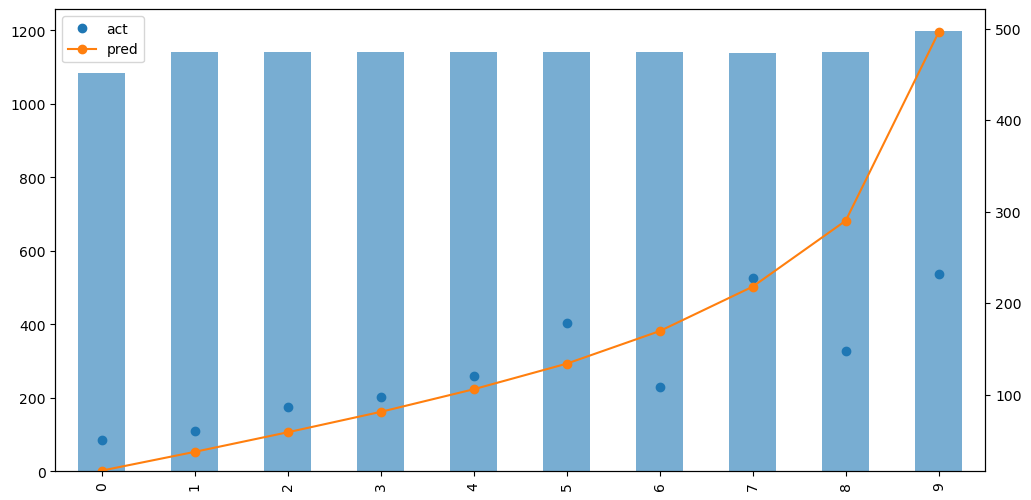

   decile   ee_col    act   pred
0    1.00 1,083.17  50.12  17.19
1    2.00 1,140.00  60.33  37.68
2    3.00 1,140.28  86.34  59.07
3    4.00 1,140.31  97.64  81.36
4    5.00 1,140.13 120.07 106.07
5    6.00 1,140.15 178.54 134.02
6    7.00 1,140.07 108.77 169.64
7    8.00 1,139.80 227.27 218.18
8    9.00 1,141.05 147.90 290.21
9   10.00 1,197.31 232.12 496.20


In [32]:
facts = ['ee_col','incloss_col','pp']
remove_fields = [
    'Severe_Problem_flag','Branded_Title_flag','Severe_Accident_flag','Other_Severe_Problem_flag','Failed_Emissions_flag','Nonsevere_Accident_flag','Damage_flag','Potential_Damage_flag','Repossession_flag','CPO_flag', #VH damage flags
    'personal_use_flag','rental_use_flag','comm_use_flag','fleet_use_flag','corp_use_flag', #VH historical ownership flags
    'current_ownership_personal','current_ownership_lease','current_ownership_corp_govt', #VH current ownership flags
    'wtd_avg_travel_time','diploma_ntile','unemployment_ntile', #geodemographics
    'pol_eff_year','commute_flag','driver_count_box','limit_bi', #policy info
    'Estimated_Current_Mileage','Estimated_Current_Mileage_null_flag','Lien_Holder', 'Annual_Mileage_Estimate', 'Annual_Mileage_Estimate_null_flag', 'Number_of_Titling_Transactions', 'Number_of_Titling_Transactions_null_flag', #VH remainder
    'Branded_Title_Loss_flag','Collision_Repair_Facility_flag', #2nd round VH damage flags
    'ded_coll','curr_owner_odo_cnt','curr_owner_odo_cnt_null_flag','Odometer_Problem_flag', #3rd round
    'single','all_owner_odo_cnt','all_owner_odo_cnt_null_flag' #4th round
    
                ]
var_list = [i for i in data1_train.columns if i not in remove_fields and i not in facts]

easy_glm(data1_train,data1_test,'pp','ee_col',var_list)

lift_chart(out_test, 'incloss_col', 'incurred_pred', 'ee_col', 10)

In [ ]:
# Next round notes

This fit is terrible and is not generalizing well at all on the test set.  This is a reasonable result given our sample size - for the purposes of class we just have to ignore it.
In the real world, we would keep removing items that do not make logical sense directionally or in magnitude.

One thing we can try here is removing Modeled_Annual_Mileage and trying Annual_Mileage_Estimate instead

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     pp   No. Observations:                80134
Model:                            GLM   Df Residuals:                    80118
Model Family:                 Tweedie   Df Model:                           15
Link Function:                    Log   Scale:                          2026.3
Method:                          IRLS   Log-Likelihood:                -24729.
Date:                Fri, 22 Mar 2024   Deviance:                   5.5576e+06
Time:                        17:01:05   Pearson chi2:                 1.62e+08
No. Iterations:                    16   Pseudo R-squ. (CS):           0.002331
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

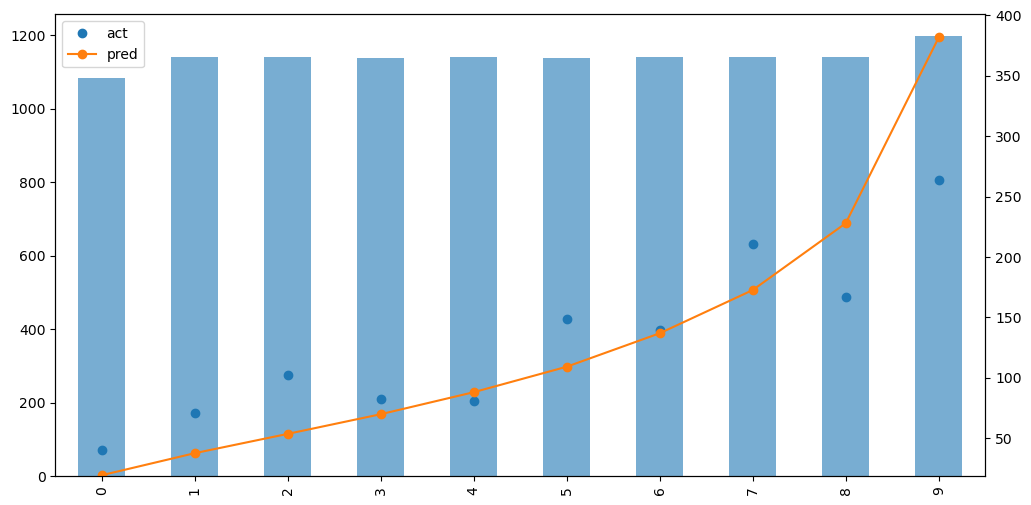

   decile   ee_col    act   pred
0    1.00 1,083.02  40.11  19.38
1    2.00 1,140.31  71.14  37.64
2    3.00 1,140.20 102.34  53.62
3    4.00 1,139.49  82.73  69.90
4    5.00 1,141.08  80.76  88.13
5    6.00 1,139.81 148.73 109.21
6    7.00 1,140.56 139.25 136.92
7    8.00 1,140.04 211.01 172.69
8    9.00 1,140.39 167.28 228.02
9   10.00 1,197.36 263.68 381.81


In [33]:
facts = ['ee_col','incloss_col','pp']
remove_fields = [
    'Severe_Problem_flag','Branded_Title_flag','Severe_Accident_flag','Other_Severe_Problem_flag','Failed_Emissions_flag','Nonsevere_Accident_flag','Damage_flag','Potential_Damage_flag','Repossession_flag','CPO_flag', #VH damage flags
    'personal_use_flag','rental_use_flag','comm_use_flag','fleet_use_flag','corp_use_flag', #VH historical ownership flags
    'current_ownership_personal','current_ownership_lease','current_ownership_corp_govt', #VH current ownership flags
    'wtd_avg_travel_time','diploma_ntile','unemployment_ntile', #geodemographics
    'pol_eff_year','commute_flag','driver_count_box','limit_bi', #policy info
    'Estimated_Current_Mileage','Estimated_Current_Mileage_null_flag','Lien_Holder', 'Modeled_Annual_Mileage', 'Modeled_Annual_Mileage_null_flag', 'Number_of_Titling_Transactions', 'Number_of_Titling_Transactions_null_flag', #VH remainder
    'Branded_Title_Loss_flag','Collision_Repair_Facility_flag', #2nd round VH damage flags
    'ded_coll','curr_owner_odo_cnt','curr_owner_odo_cnt_null_flag','Odometer_Problem_flag', #3rd round
    'single','all_owner_odo_cnt','all_owner_odo_cnt_null_flag' #4th round
    
                ]
var_list = [i for i in data1_train.columns if i not in remove_fields and i not in facts]

easy_glm(data1_train,data1_test,'pp','ee_col',var_list)

lift_chart(out_test, 'incloss_col', 'incurred_pred', 'ee_col', 10)

In [ ]:
# Notes

The fit generalized less poorly, but the training data signal is not allowing the feature to be statistically significant

Lets see what happens if we remove both

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     pp   No. Observations:                80134
Model:                            GLM   Df Residuals:                    80120
Model Family:                 Tweedie   Df Model:                           13
Link Function:                    Log   Scale:                          2047.0
Method:                          IRLS   Log-Likelihood:                -24754.
Date:                Fri, 22 Mar 2024   Deviance:                   5.5613e+06
Time:                        17:01:06   Pearson chi2:                 1.64e+08
No. Iterations:                    16   Pseudo R-squ. (CS):           0.002285
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -139.5926    

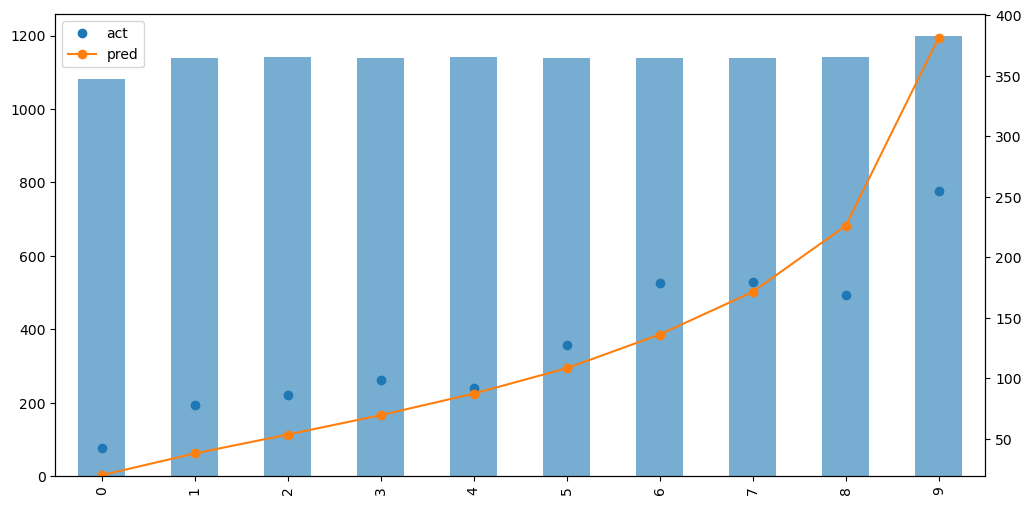

   decile   ee_col    act   pred
0    1.00 1,083.01  42.74  20.06
1    2.00 1,140.01  77.80  38.04
2    3.00 1,140.25  86.07  53.62
3    4.00 1,140.05  98.87  69.67
4    5.00 1,140.73  92.39  87.42
5    6.00 1,139.87 127.81 108.46
6    7.00 1,139.70 178.82 136.27
7    8.00 1,140.22 179.30 171.54
8    9.00 1,140.78 168.61 226.19
9   10.00 1,197.64 255.13 381.66


In [34]:
facts = ['ee_col','incloss_col','pp']
remove_fields = [
    'Severe_Problem_flag','Branded_Title_flag','Severe_Accident_flag','Other_Severe_Problem_flag','Failed_Emissions_flag','Nonsevere_Accident_flag','Damage_flag','Potential_Damage_flag','Repossession_flag','CPO_flag', #VH damage flags
    'personal_use_flag','rental_use_flag','comm_use_flag','fleet_use_flag','corp_use_flag', #VH historical ownership flags
    'current_ownership_personal','current_ownership_lease','current_ownership_corp_govt', #VH current ownership flags
    'wtd_avg_travel_time','diploma_ntile','unemployment_ntile', #geodemographics
    'pol_eff_year','commute_flag','driver_count_box','limit_bi', #policy info
    'Estimated_Current_Mileage','Estimated_Current_Mileage_null_flag','Lien_Holder', 'Modeled_Annual_Mileage', 'Modeled_Annual_Mileage_null_flag', 'Number_of_Titling_Transactions', 'Number_of_Titling_Transactions_null_flag', #VH remainder
    'Branded_Title_Loss_flag','Collision_Repair_Facility_flag', #2nd round VH damage flags
    'ded_coll','curr_owner_odo_cnt','curr_owner_odo_cnt_null_flag','Odometer_Problem_flag', #3rd round
    'single','all_owner_odo_cnt','all_owner_odo_cnt_null_flag', #4th round
    'Annual_Mileage_Estimate', 'Annual_Mileage_Estimate_null_flag' #5th round
    
                ]
var_list = [i for i in data1_train.columns if i not in remove_fields and i not in facts]

easy_glm(data1_train,data1_test,'pp','ee_col',var_list)

lift_chart(out_test, 'incloss_col', 'incurred_pred', 'ee_col', 10)

In [ ]:
# Notes

Its about the same on the test data
With small data this can easily happen; what I would suggest to do is do all of this over again using cross validation on the one big dataset

### Lesson 6 Exercise 1
#### Together as class, use your searching skills to figure out how to create a correlation matrix of the model inputs
#### Also together, figure out how to calculate the VIF

In [38]:
corr = data1_train[(var_list)].corr()
corr.style.background_gradient(cmap='coolwarm')

,modelyear,credit,veh_count_box,veh_age_box,coll_symb_ntile,DrvAge_box,male,widowed,LOO_years,lease_flag,pop_density_ntile,modelyear_null_flag,LOO_years_null_flag
modelyear,1.000000,0.067585,-0.039403,-0.895703,0.037099,-0.059477,-0.001245,-0.009966,-0.476094,0.127032,0.051430,0.000250,0.153781
credit,0.067585,1.000000,-0.067218,-0.072777,0.042297,-0.307210,-0.019855,-0.050942,-0.220475,0.102104,0.037413,0.001825,0.017275
veh_count_box,-0.039403,-0.067218,1.000000,0.029583,0.020482,-0.092544,0.062553,-0.180715,0.009778,-0.021084,-0.101530,0.006904,0.009560
veh_age_box,-0.895703,-0.072777,0.029583,1.000000,-0.005304,0.050283,-0.002493,0.018258,0.536580,-0.129983,-0.042810,0.150435,-0.101451
coll_symb_ntile,0.037099,0.042297,0.020482,-0.005304,1.000000,-0.058492,0.025933,-0.015943,-0.021936,0.028057,0.020466,0.001363,0.024572
DrvAge_box,-0.059477,-0.307210,-0.092544,0.050283,-0.058492,1.000000,0.005619,0.241283,0.167784,-0.065469,-0.029474,0.005417,0.004238
male,-0.001245,-0.019855,0.062553,-0.002493,0.025933,0.005619,1.000000,-0.124885,-0.011310,-0.016363,-0.023414,0.001879,0.007347
widowed,-0.009966,-0.050942,-0.180715,0.018258,-0.015943,0.241283,-0.124885,1.000000,0.029649,-0.014502,0.007755,0.015472,-0.001117
LOO_years,-0.476094,-0.220475,0.009778,0.536580,-0.021936,0.167784,-0.011310,0.029649,1.000000,-0.178567,-0.011306,0.002767,0.002253
lease_flag,0.127032,0.102104,-0.021084,-0.129983,0.028057,-0.065469,-0.016363,-0.014502,-0.178567,1.000000,0.059466,-0.063113,-0.140204


In [ ]:
### VIF

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

model_vars = [i for i in var_list if 'null_flag' not in i]

df = data1_train[(model_vars)].copy()

X = add_constant(df)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const               636,224.22
modelyear                 5.10
credit                    1.16
veh_count_box             1.06
veh_age_box               5.54
coll_symb_ntile           1.01
DrvAge_box                1.20
male                      1.02
widowed                   1.11
LOO_years                 1.51
lease_flag                1.04
pop_density_ntile         1.02
dtype: float64